# Описание задачи и подгружаемые библиотеки

In [1]:
# Описание задачи
# Задание 
# -сделать модель, предсказывающую вероятность дефолта (таргет fpd5_flg), 


# -на выходе должен быть тот же самый файл, но напротив каждого наблюдения 
# должна быть проставлена вероятность дефолта по построенной модели


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import  tqdm
import numpy as np


from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [3]:
data_initial = pd.read_excel('./Test Sample.xlsx')

In [4]:
data = data_initial.copy()

In [5]:
data.head(5)

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index
0,0,2021-01-22,0,NaN,NaN,UMID,26,GMAIL.COM,Private Company Employee,20000.0,Bank,Android,0.0
1,0,2020-12-14,1,3.0,4.0,UMID,32,GMAIL.COM,Other,18000.0,E-wallet,Android,1.0
2,1,2021-01-26,0,0.0,3.0,SSS,41,YAHOO.COM,Private Company Employee,14000.0,Bank,Android,1.0
3,1,2020-12-10,1,0.0,5.0,TIN,28,GMAIL.COM,BPO Professionals,40000.0,E-wallet,Android,1.0
4,1,2021-01-17,0,3.0,3.0,UMID,31,GMAIL.COM,BPO Professionals,25000.0,Bank,Android,0.0


In [6]:
data.shape

(15363, 13)

# EDA

## Поиск и редактирование выбросов

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   14798 non-null  float64
 4   behavioral_index        14798 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  14649 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15347 non-null  object 
 12  email_index             15330 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1.5+ MB


In [8]:
#проверка на наличие бредовых значений, на подобии отрицательных в возрасте или зп, или слишком больших, где их быть не может 
data.describe().iloc[:,1:13]

,gender,device_quaility_index,behavioral_index,age,salary,email_index
count,15363.000000,14798.000000,14798.000000,15363.000000,1.464900e+04,15330.000000
mean,0.629109,2.369982,4.051291,35.135781,1.261647e+05,1.580039
std,0.483059,1.077686,0.937965,9.125229,1.239332e+07,2.397705
min,0.000000,0.000000,1.000000,21.000000,0.000000e+00,0.000000
25%,0.000000,2.000000,3.000000,28.000000,1.500000e+04,0.000000
50%,1.000000,3.000000,4.000000,34.000000,2.000000e+04,1.000000
75%,1.000000,3.000000,5.000000,41.000000,2.600000e+04,1.000000
max,1.000000,4.000000,6.000000,69.000000,1.500020e+09,12.000000


In [9]:
# ==> явный выброс в зарплате

In [10]:
#удалим сразу значение больше миллиарда
#пока нет смысла использовать метод удаления выбросов ориентруясь на квантили, потому что  
# зарплат, которые выше чем квантиль99 может быть достаточно много, при условии расслоения общества,
# а они пойдут в выбросы и будут удалены, что не верно 
data['salary'] = data['salary'].apply(lambda x: 0 if x>1000000000 else x)  #1000000000

У 90% людей из выборки зп не превышает 35000


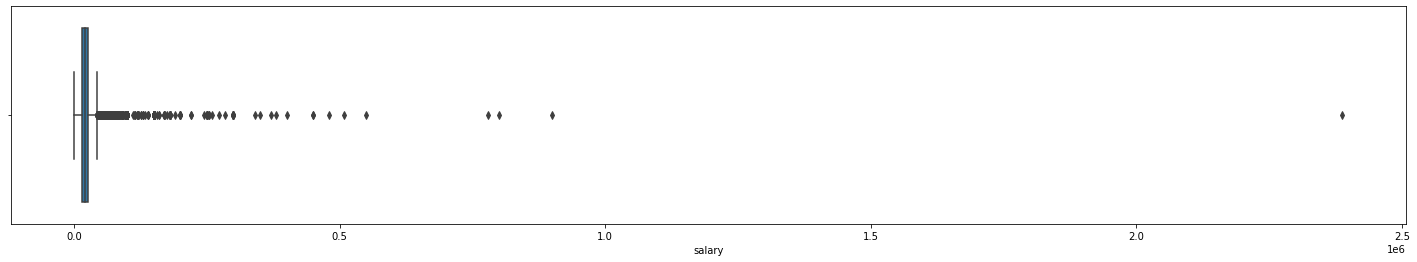

In [11]:
#получаем достаточно реальную картину 
plt.figure(figsize=(25, 4))
sns.boxplot(x = data['salary'])
print('У 90% людей из выборки зп не превышает', int(data['salary'].quantile(0.90)))

In [12]:
# ==> достаточно реальные цифры, учитывая экономические реалии Филиппин

## Работа с пропусками

### Поиск пропусков

<AxesSubplot:>

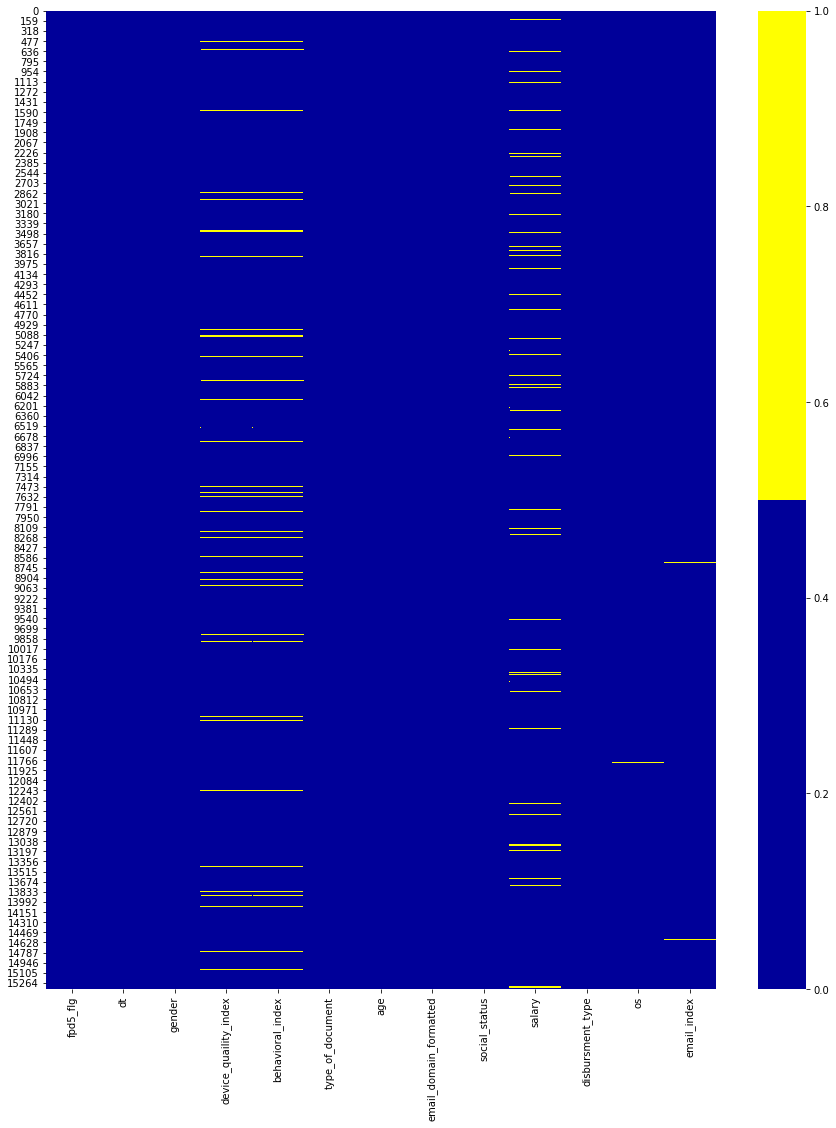

In [13]:
#построение тепловой карты пропусков
plt.figure(figsize=(15, 18))
colours = ['#000099', '#ffff00'] 
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   14798 non-null  float64
 4   behavioral_index        14798 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  14649 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15347 non-null  object 
 12  email_index             15330 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1.5+ MB


In [15]:
15363 - 14798 

565

In [16]:
#пропуски обнаружены в:
# device_quaility_index, behavioral_index - одинаковое кол-во пропусков + судя по тепловой карте скорее, всего в одних и тех же строках   
# salary  
# os
# email_index

In [17]:
#Посмотрим на то, как распределены данные 
col = ['gender',
 'device_quaility_index',
 'behavioral_index',
 'type_of_document',
 'email_domain_formatted',
 'social_status',
 'disbursment_type',
 'os',
 'email_index']
for column in col:
    a = data[column].value_counts()
    print(a)
    print('==============================================')

1    9665
0    5698
Name: gender, dtype: int64
3.0    7837
1.0    2374
2.0    2337
4.0    1128
0.0    1122
Name: device_quaility_index, dtype: int64
4.0    4721
3.0    4675
5.0    4447
6.0     730
2.0     202
1.0      23
Name: behavioral_index, dtype: int64
UMID                 5419
Driver license ID    3073
TIN                  3057
Passport             1867
SSS                  1498
PRC                   449
Name: type_of_document, dtype: int64
GMAIL.COM         12109
YAHOO.COM          2626
YAHOO.COM.PH        182
DEPED.GOV.PH        100
ICLOUD.COM           88
                  ...  
UAP.ASIA              1
MERALCO.COM.PH        1
DLSL.EDU.PH           1
GXII.COM.PH           1
PPD.PH                1
Name: email_domain_formatted, Length: 95, dtype: int64
Private Company Employee                                       3500
Self-Employed                                                  2323
BPO Professionals                                              2295
Other                     

### Заполнение пропусков в признаке Salary

In [18]:
#кол-во пустых значений
15363 - 14649 

714

In [19]:
data.salary.describe()

count    1.464900e+04
mean     2.376730e+04
std      3.180815e+04
min      0.000000e+00
25%      1.500000e+04
50%      2.000000e+04
75%      2.600000e+04
max      2.387700e+06
Name: salary, dtype: float64

In [20]:
# получим кол-во людей не подавших данные о зп, это оказываются люди на пенсии и безработные, то есть разумно заменить пустые значения в данном признаке на нули
data.salary=data[['salary']].fillna(999) 
data.query('salary == 999').groupby('social_status').agg({'social_status': 'count'}).rename(columns={'social_status':'count'})

,count
social_status,
Other,1
Retired,90
Self-Employed,1
Unemployed,622


In [21]:
data.salary = data.salary.apply(lambda x: 0 if x==999 else x)

### Заполнение пропусков в признаке OS

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   14798 non-null  float64
 4   behavioral_index        14798 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  15363 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15347 non-null  object 
 12  email_index             15330 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1.5+ MB


In [23]:
#кол-во пропусков
data.shape[0] - 15347

16

<AxesSubplot:xlabel='device_quaility_index', ylabel='count'>

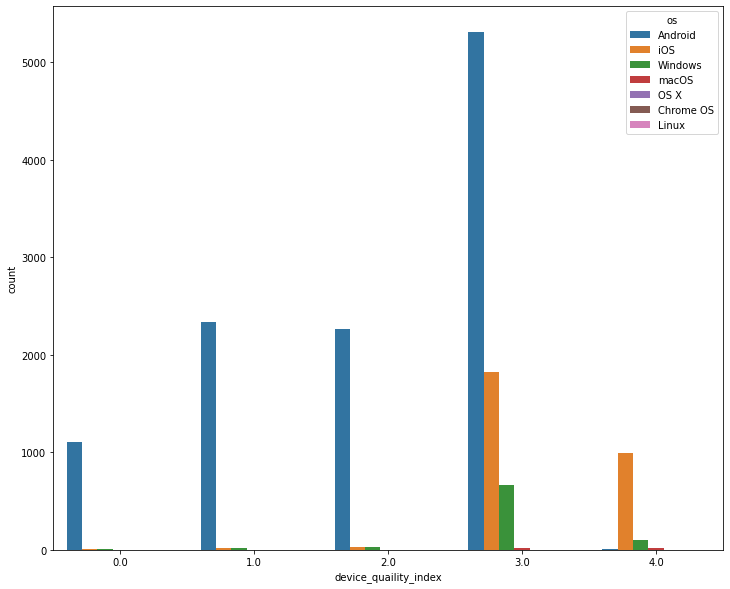

In [24]:
#вероятно данный признак связан c device_quaility_index    
plt.figure(figsize=(12, 10))
sns.countplot(x=data['device_quaility_index'], hue=data['os'])

In [25]:
# ==> исходя из графика видно чёткое отсечение индексов качества устройства к принадлежности ОС, 
# если индекс = 0, 1, 2, 3 то это скорее всего андроид, если 4 то скорее всего ios

In [26]:
data_for_testing = data.copy() #чтобы не трогать изначальный датасет создаётся черновой

In [27]:
# ос может зависеть от проф деятельности, от достатка и от возраста

data_for_testing['salary_group'] = pd.cut(data_for_testing['salary']\
    , bins=[data_for_testing.salary.min(), 15000, 30000, data_for_testing.salary.max()], include_lowest=True, labels=['1', '2', '3'])\
        .astype(object)

data_for_testing['age_group'] = pd.cut(data_for_testing['age']\
    , bins=[data_for_testing.age.min(), 35, 60, data_for_testing.age.max()], include_lowest=True, labels=['1', '2', '3'])\
        .astype(object)

<AxesSubplot:xlabel='salary_group', ylabel='count'>

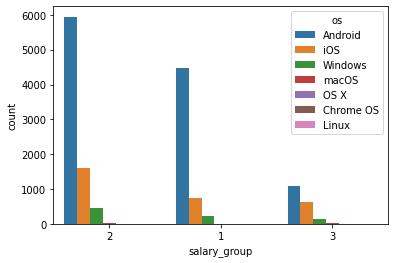

In [28]:
plt.figure(figsize=(6, 4))
sns.countplot(x=data_for_testing['salary_group'], hue=data['os'])

<AxesSubplot:xlabel='age_group', ylabel='count'>

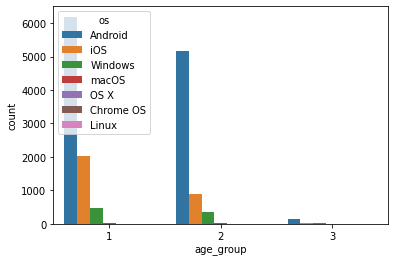

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(x=data_for_testing['age_group'], hue=data['os'])

In [30]:
# ==>распредление по групам и визуальный осмотр статистики не дал особых результатов, 
# самое адекватное это воспользоваться логикой исходя из графика зависимости device_quaility_index

In [31]:
# замени пустые значения на 999, чтобы с ними было проще работать
data.os = data.os.fillna(999)

In [32]:
#заменим значения с индексом 4 на ios, всем остальным пропускам поставим Android
data['os'].mask((data['os']==999) & (data['device_quaility_index']==4) , 'iOS', inplace=True)
data['os'].mask(data['os']==999, 'Android', inplace=True)

In [33]:
data.os.value_counts()

Android      11513
iOS           2949
Windows        845
macOS           40
Linux            7
Chrome OS        5
OS X             4
Name: os, dtype: int64

### Заполнение пропусков в признаке email_index             

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   14798 non-null  float64
 4   behavioral_index        14798 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  15363 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15363 non-null  object 
 12  email_index             15330 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1.5+ MB


In [35]:
data.email_index.value_counts()

1.0     8926
0.0     4253
8.0     1329
6.0      273
4.0      232
10.0     176
2.0      129
3.0        7
12.0       4
11.0       1
Name: email_index, dtype: int64

In [36]:
#кол-во пропусков
data.shape[0]-15330 

33

In [37]:
#скорее всего данный признак связан с email_domain_formatted  

In [38]:
#список самых популярных доменов
top_ten = list(data.email_domain_formatted.value_counts().head(10).reset_index()['index'].values)
top_ten

['GMAIL.COM',
 'YAHOO.COM',
 'YAHOO.COM.PH',
 'DEPED.GOV.PH',
 'ICLOUD.COM',
 'YMAIL.COM',
 'ROCKETMAIL.COM',
 'HOTMAIL.COM',
 'OUTLOOK.COM',
 'EMAIL.COM']

In [39]:
#таблица только с популярными доменами составила 99% всей таблицы 
top_domain_data = data.query('email_domain_formatted == %s'%top_ten)
top_domain_data.shape

(15260, 13)

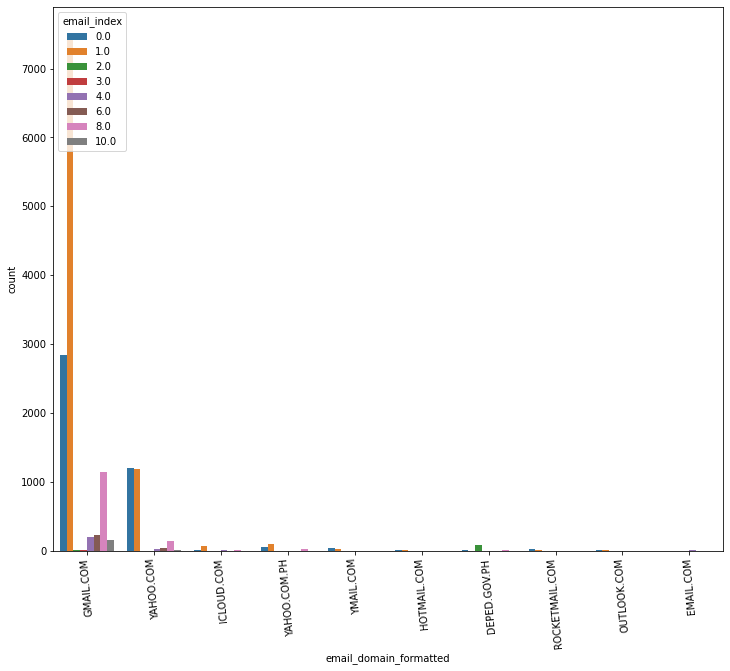

In [40]:
plt.figure(figsize=(12, 10))
sns.countplot(x=top_domain_data['email_domain_formatted'], hue=top_domain_data['email_index'])
plt.xticks(rotation=95);

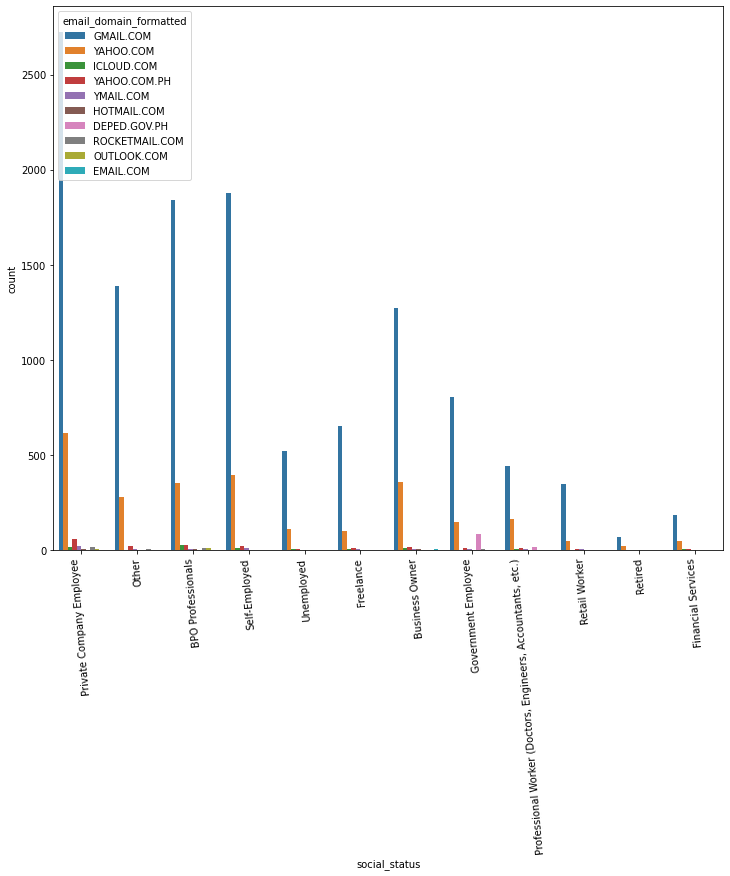

In [41]:
#Проверим как распределяется формат домена исходя из социального статуса
plt.figure(figsize=(12, 10))
sns.countplot(x=top_domain_data['social_status'], hue=top_domain_data['email_domain_formatted'])
plt.xticks(rotation=95);

In [42]:
#Выделим самые популярные индексы в каждом из топ10 самых популярных доменов и получим самые частые значениям 0 и 1
top_dom_table = top_domain_data.groupby('email_domain_formatted').email_index.apply(lambda x: x.mode()).reset_index().drop('level_1', axis=1)
top_dom_table

,email_domain_formatted,email_index
0,DEPED.GOV.PH,2.0
1,EMAIL.COM,4.0
2,GMAIL.COM,1.0
3,HOTMAIL.COM,0.0
4,ICLOUD.COM,1.0
5,OUTLOOK.COM,1.0
6,ROCKETMAIL.COM,0.0
7,YAHOO.COM,0.0
8,YAHOO.COM.PH,1.0
9,YMAIL.COM,0.0


In [43]:
#принято решение по замене значений пропусков там где домен gmail присвоить 1, остальным 0, 
# учитывая что пропусков всего 33, значимость ошибки будет крайне мала

In [44]:
data['email_index'] = data['email_index'].fillna(999)
data['email_index'] = data['email_index'].fillna(lambda x: 1 if data.email_domain_formatted=="GMAIL.COM" else 0)
# data['email_index2'] = data.email_index

In [45]:
data['email_index'].mask((data['email_index']==999) & (data['email_domain_formatted']=='GMAIL.COM') , 1, inplace=True)
data['email_index'].mask(data['email_index']==999, 0, inplace=True)

### Заполнение пропусков в признаке behavioral_index

In [46]:
data.shape[0] - 14798 

565

In [47]:
#убедимся, что в признаках device_quaility_index и behavioral_index отсутствия данных парные, то есть индексы отсутствующих данных равны
a = data.shape[0] - 14798 # кол-во отсутствующих 
NanVal_in_qualind_behind = data[['device_quaility_index', 'behavioral_index']].fillna(777)\
    .query('device_quaility_index==777 and behavioral_index==777')
if NanVal_in_qualind_behind.shape[0] == a:
    print('True')

True


<AxesSubplot:>

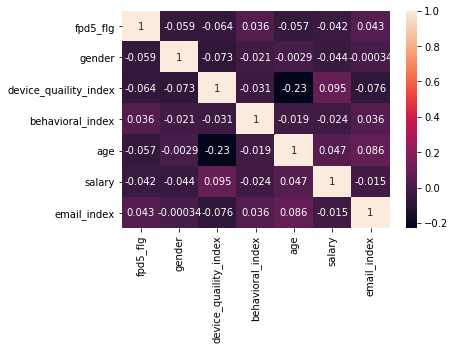

In [48]:
#посмотрим на линейные корреляции количественных перменных, дабы оценить степень взаимосвязи данных и оценить возможно ли использовать 
# корреляцию для решения проблемы пустых значениц двух оставшихся признаков
sns.heatmap(data.corr(), annot=True)

In [49]:
# ==> связей нет

In [50]:
#Что может влиять на поведенческий индекс? Это социальный статус, тип документа предоставленного, возраст

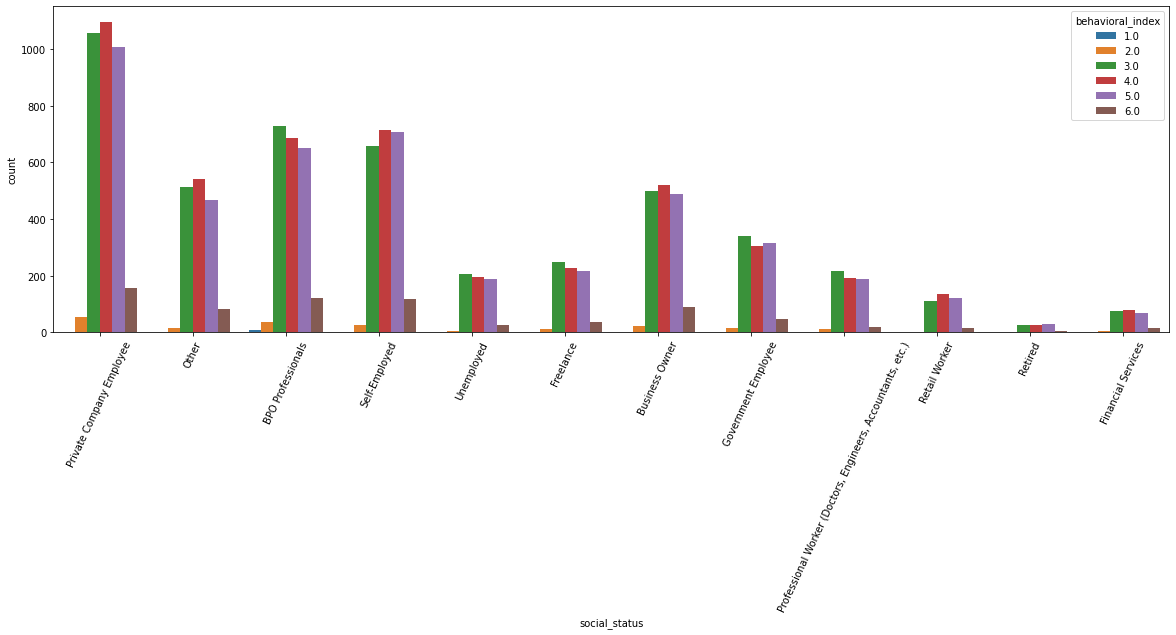

In [51]:
# ==> у большинства людей всех соц статусов поведенческий индекс 3, 4, 5
plt.figure(figsize=(20, 6))
sns.countplot(x=data_for_testing['social_status'], hue=data_for_testing['behavioral_index'])
plt.xticks(rotation=65);

In [52]:
data_for_testing.type_of_document.value_counts()

UMID                 5419
Driver license ID    3073
TIN                  3057
Passport             1867
SSS                  1498
PRC                   449
Name: type_of_document, dtype: int64

<AxesSubplot:xlabel='type_of_document', ylabel='count'>

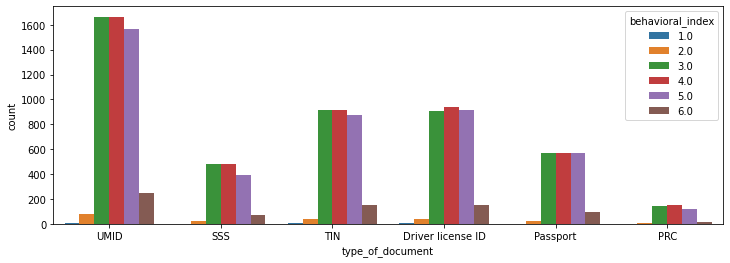

In [53]:
# The Unified Multi-Purpose ID (UMID) is a Philippine identity card which was introduced in 2010. 
# The card was developed as a single card for the relations between several government-related agencies.

# A Taxpayer Identification Number (TIN) is an identification number used by the Internal Revenue Service (IRS) 
# in the administration of tax laws. ... A Social Security number (SSN) is issued by the SSA whereas all other TINs are issued by the IRS

# Republic of the Philippines Social Security System

# The Professional Regulation Commission (PRC), the agency mandated to implement the regulatory laws and 
# policies for the various regulated professions

#в каждом типе документов также лидируют эти 3 индекса поведения 
plt.figure(figsize=(12, 4))
sns.countplot(x=data_for_testing['type_of_document'], hue=data_for_testing['behavioral_index'])

<AxesSubplot:xlabel='salary_group', ylabel='count'>

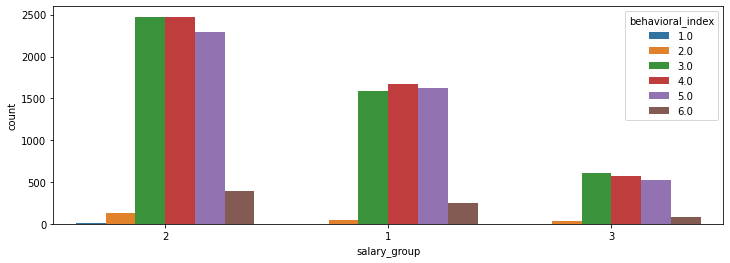

In [54]:
#среди груп разделенных по доходам также лидируют данные индексы 
plt.figure(figsize=(12, 4))
sns.countplot(x=data_for_testing['salary_group'], hue=data_for_testing['behavioral_index'])

<AxesSubplot:xlabel='age_group', ylabel='count'>

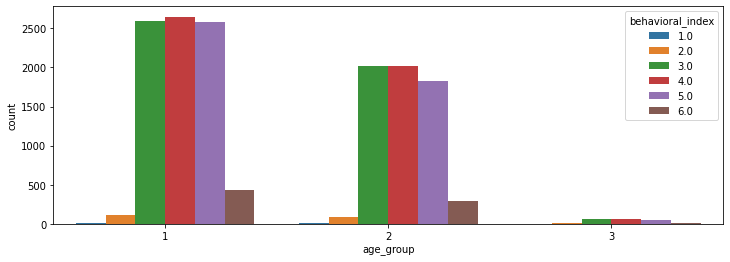

In [55]:
#Среди возрастных групп статистика повторяется 
plt.figure(figsize=(12, 4))
sns.countplot(x=data_for_testing['age_group'], hue=data_for_testing['behavioral_index'])

In [56]:
data_for_testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   14798 non-null  float64
 4   behavioral_index        14798 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  15363 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15347 non-null  object 
 12  email_index             15330 non-null  float64
 13  salary_group            15363 non-null  object 
 14  age_group               15363 non-null

In [57]:
#соединими три признака чтобы попытаться получить индексное разнообразие 
data_for_testing['behav_feat'] = data_for_testing['fpd5_flg'].astype(str) + data_for_testing['social_status']  + data_for_testing['salary_group']
bev_tab = pd.DataFrame(data_for_testing.groupby('behav_feat').behavioral_index.apply(lambda x: x.mode())).reset_index()
# bev_tab.behav_feat = bev_tab.behav_feat.apply(lambda x: x[:-2])
bev_tab = bev_tab.drop('level_1', axis=1)
bev_tab.behavioral_index.value_counts() 
# ==> даже так остаются только индексы 3, 4, 5

3.0    27
4.0    27
5.0    19
Name: behavioral_index, dtype: int64

In [58]:
# будем применять маску к данным полученным из взаимосвязи с социальным статусом
behavind_per_socstat = pd.DataFrame(data.groupby('social_status').behavioral_index.apply(lambda x: x.mode())).reset_index().drop('level_1', axis=1)
behavind_per_socstat
#самые популярные поведенческие индексы в соц статусе:

,social_status,behavioral_index
0,BPO Professionals,3.0
1,Business Owner,4.0
2,Financial Services,4.0
3,Freelance,3.0
4,Government Employee,3.0
5,Other,4.0
6,Private Company Employee,4.0
7,"Professional Worker (Doctors, Engineers, Accou...",3.0
8,Retail Worker,4.0
9,Retired,5.0


In [59]:
data['behavioral_index'] = data['behavioral_index'].fillna(999)

#пустые значения заменяются на самые популярные в каждой соц группе

index_list = list(behavind_per_socstat.behavioral_index.unique()) 

for beh_index in index_list:
    val_list = list(behavind_per_socstat.query('behavioral_index == %s'%beh_index).social_status)
    for val in val_list:
        data['behavioral_index'].mask((data['behavioral_index']==999) & (data['social_status']== (val)), beh_index, inplace=True)

In [60]:
data.query('behavioral_index == 999')

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index


### Заполнение пропусков в признаке device_quaility_index

In [61]:
data.shape[0] - 14798 

565

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   14798 non-null  float64
 4   behavioral_index        15363 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  15363 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15363 non-null  object 
 12  email_index             15363 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1.5+ MB


In [63]:
#индекс качества девайса может зависеть от os которое установлено в устройстве, косвенно от зарплаты и возраста

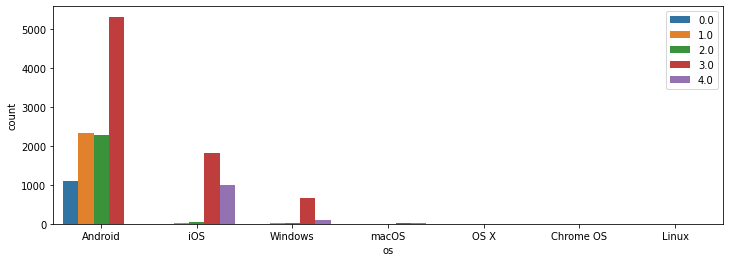

In [64]:
#зависимость индекса девайса от ос
plt.figure(figsize=(12, 4))
sns.countplot(x=data_for_testing['os'], hue=data_for_testing['device_quaility_index'])
plt.legend(loc='upper right')

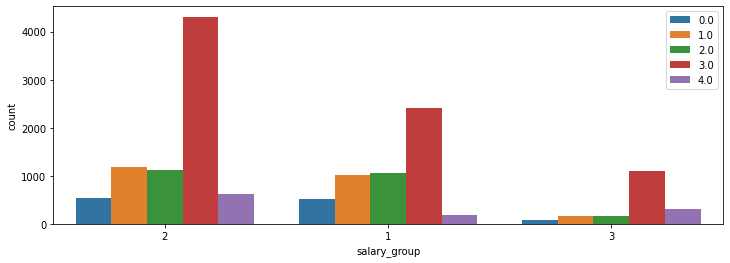

In [65]:
#зависимость индекса девайся от зарплатной группы
plt.figure(figsize=(12, 4))
sns.countplot(x=data_for_testing['salary_group'], hue=data_for_testing['device_quaility_index'])
plt.legend(loc='upper right')

<AxesSubplot:xlabel='age_group', ylabel='count'>

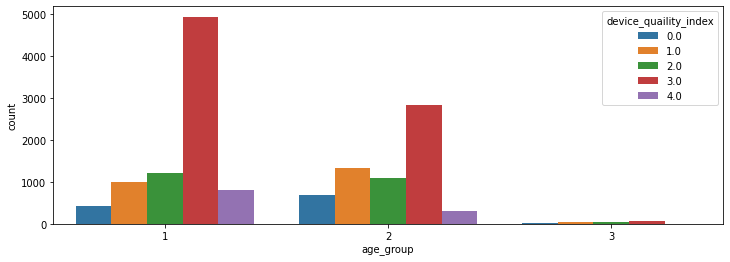

In [66]:
#зависимость индекса девайся от возрастной группы
plt.figure(figsize=(12, 4))
sns.countplot(x=data_for_testing['age_group'], hue=data_for_testing['device_quaility_index'])

In [67]:
#добавим в основной датасет признаки salary_group и age_group 
data['salary_group'] = pd.cut(data['salary']\
    , bins=[data.salary.min(), 15000, 30000, data.salary.max()], include_lowest=True, labels=['1', '2', '3'])\
        .astype(object)

data['age_group'] = pd.cut(data['age']\
    , bins=[data.age.min(), 35, 60, data.age.max()], include_lowest=True, labels=['1', '2', '3'])\
        .astype(object)

In [68]:
#добавим в основной датасет собирательную фичу по трём вышеприведенным признакам
data['def_fit'] = data['age_group'] + data['salary_group'] + data['os']

#таблица с самыми популярными индексами качества на каждую комбинацию 
def_qual_table = pd.DataFrame(data.groupby('def_fit').device_quaility_index.apply(lambda x: x.mode())).reset_index().drop('level_1', axis=1)
def_qual_table.head(50)

,def_fit,device_quaility_index
0,11Android,3.0
1,11Windows,3.0
2,11iOS,3.0
3,11macOS,3.0
4,12Android,3.0
5,12Chrome OS,3.0
6,12Linux,3.0
7,12OS X,4.0
8,12Windows,3.0
9,12iOS,3.0


In [69]:
data['device_quaility_index'] = data['device_quaility_index'].fillna(999)

#пустые значения заменяются на самые популярные в каждом значении признака, что состоит из трёх 

index_list1 = list(def_qual_table.device_quaility_index.unique()) 

for qual_index in index_list1:  
    val_list = list(def_qual_table.query('device_quaility_index == %s'%qual_index).def_fit) 
    for val in val_list:
        data['device_quaility_index'].mask((data['device_quaility_index']==999) & (data['def_fit']== (val)), qual_index, inplace=True) 


## Работа с дубликатами

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   15363 non-null  float64
 4   behavioral_index        15363 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  15363 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15363 non-null  object 
 12  email_index             15363 non-null  float64
 13  salary_group            15363 non-null  object 
 14  age_group               15363 non-null

In [71]:
data[data.duplicated(keep=False)]

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index,salary_group,age_group,def_fit
1420,1,2020-12-28,1,3.0,3.0,UMID,23,GMAIL.COM,BPO Professionals,20000.0,Bank,Android,1.0,2,1,12Android
4660,0,2020-12-11,1,2.0,3.0,UMID,28,GMAIL.COM,Other,15000.0,Bank,Android,8.0,1,1,11Android
6860,1,2020-12-28,1,3.0,3.0,UMID,23,GMAIL.COM,BPO Professionals,20000.0,Bank,Android,1.0,2,1,12Android
10598,0,2020-12-11,1,2.0,3.0,UMID,28,GMAIL.COM,Other,15000.0,Bank,Android,8.0,1,1,11Android
11058,0,2020-12-09,1,3.0,4.0,Driver license ID,33,GMAIL.COM,Other,22000.0,E-wallet,Android,1.0,2,1,12Android
11059,0,2020-12-09,1,3.0,4.0,Driver license ID,33,GMAIL.COM,Other,22000.0,E-wallet,Android,1.0,2,1,12Android
13680,0,2020-12-14,0,2.0,4.0,TIN,29,GMAIL.COM,Government Employee,18000.0,Bank,Android,8.0,2,1,12Android
13681,0,2020-12-14,0,2.0,4.0,TIN,29,GMAIL.COM,Government Employee,18000.0,Bank,Android,8.0,2,1,12Android


In [72]:
# data.drop_duplicates() #нет особого смысла удалять повторы, потому что их мало, что никак не повлияет на качество модели, 
# но зато надо будет держать в памяти датасет с нужным кол-вом строк для финального предсказания вероятностей 

## Работа с неинформативными признаки 

In [73]:
#Поиск колонок, где одно и то же значение занимает более 95% пространства колонки

In [74]:
num_rows = len(data.index)
low_information_cols = [] 

for col in data.columns:
    cnts = data[col].value_counts()
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.5:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        # print(cnts) #какие именно значения сколько раз встречаются
        print('______________________________________')

fpd5_flg: 72.72017%
______________________________________
gender: 62.91089%
______________________________________
device_quaility_index: 54.12354%
______________________________________
email_domain_formatted: 78.81924%
______________________________________
disbursment_type: 58.04856%
______________________________________
os: 74.93979%
______________________________________
email_index: 58.26336%
______________________________________
salary_group: 52.36607%
______________________________________
age_group: 56.99408%
______________________________________


In [75]:
# ==>неинформативных признаков не обнаружено

## Добавление новых признаков 

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   15363 non-null  float64
 4   behavioral_index        15363 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  15363 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15363 non-null  object 
 12  email_index             15363 non-null  float64
 13  salary_group            15363 non-null  object 
 14  age_group               15363 non-null

In [77]:
#уже есть 2 неплохие фичи, которые делят людей по возрастным группам людей среднего возраста первой категории, 
# среднего возраста второй категории, и пожилых 

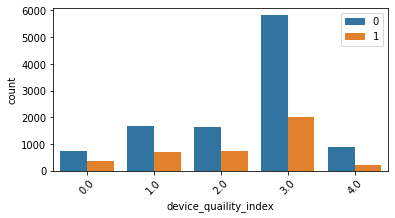

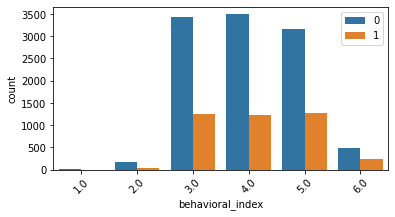

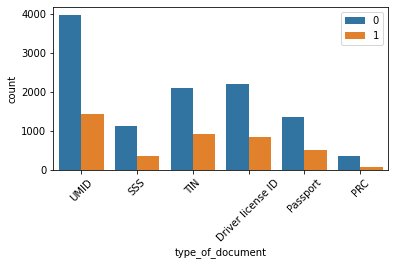

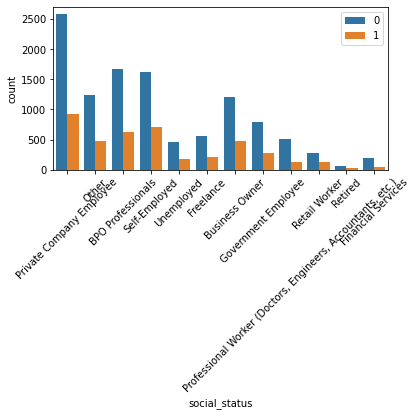

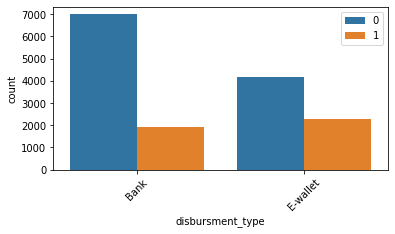

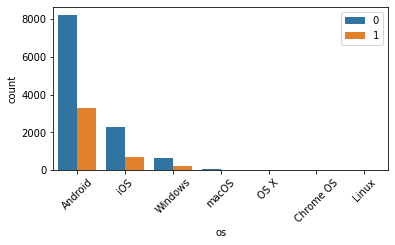

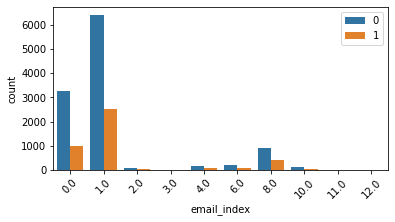

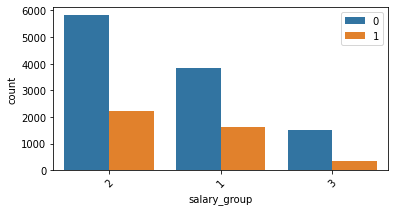

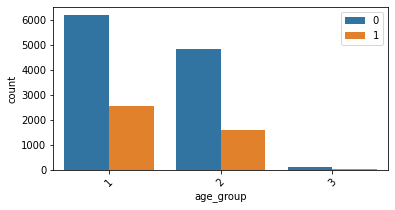

In [78]:
#посмотрим как обстоит дела с распределением у признаков относительно лейбла
col_list = ['device_quaility_index', 'behavioral_index',
       'type_of_document', 'social_status',
       'disbursment_type', 'os', 'email_index', 'salary_group',
       'age_group']

for col in col_list:
       plt.figure(figsize=(6, 3))
       sns.countplot(x=data_for_testing['%s'%col], hue=data_for_testing['fpd5_flg'])
       plt.legend(loc='upper right')
       plt.xticks(rotation=45)


In [79]:
#Анализ даты получения крелита
#Предположение: если человек берет кредит в начале месяца (30, 31, 1, 16 число ), в середине или конце то это подозрительно, 
# потому что по закону зп выдаётся два раза в месяц, а значит человек который берет кредит в день зп является потенциальным неплательщиком кредита 
# С другой стороны, люди которые берут кредит за пару дней до зп, скорее всего его выплатят, т.к. эти деньги берут, чтобы дотянуть до выплат 

<AxesSubplot:xlabel='index', ylabel='dt'>

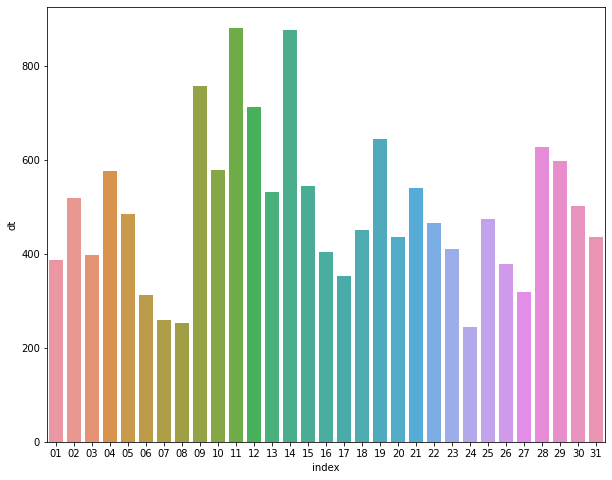

In [80]:
 #Посмотрим на распределение кол-ва взятых кредитов на даты 
plt.figure(figsize=(10, 8))
date = pd.DataFrame(data[['dt']].dt.apply(lambda x: x[8:]).value_counts()).reset_index().sort_values(by='index')
sns.barplot(x=date['index'], y=date.dt)

In [81]:
data['day'] = data['dt'].apply(lambda x: x[8:])

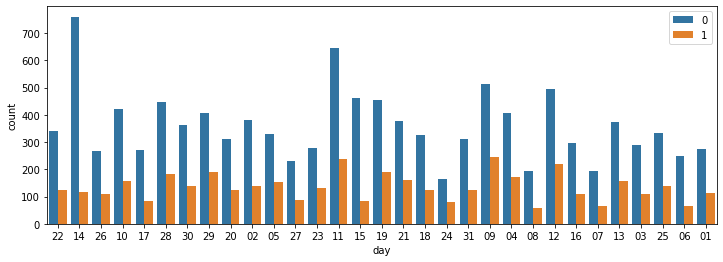

In [82]:
plt.figure(figsize=(12, 4))
ax = sns.countplot(x=data.day, hue=data['fpd5_flg'])
plt.legend(loc='upper right')
#построим такие таблицы только сразу с отражением процентного соотношения дефолта/не дефолта по каждому признаку 

In [83]:
data.email_index.nunique()

10

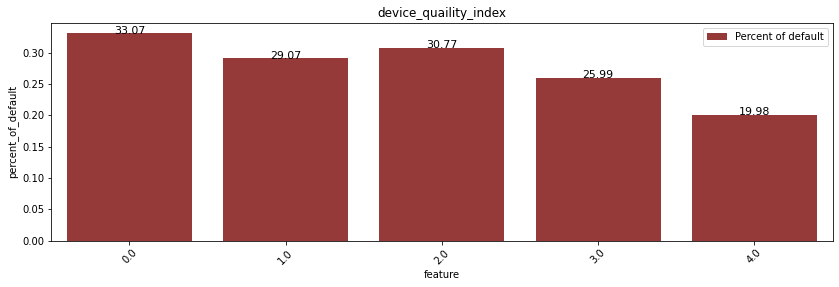

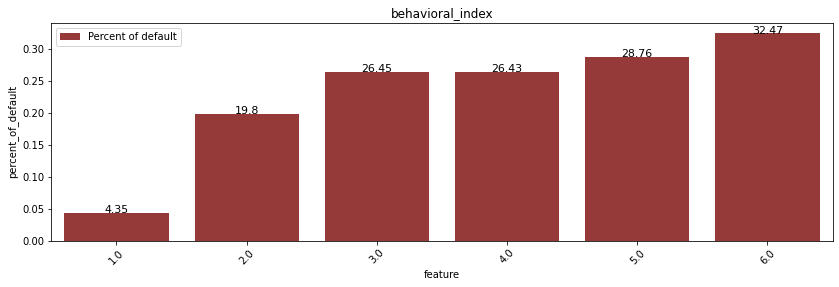

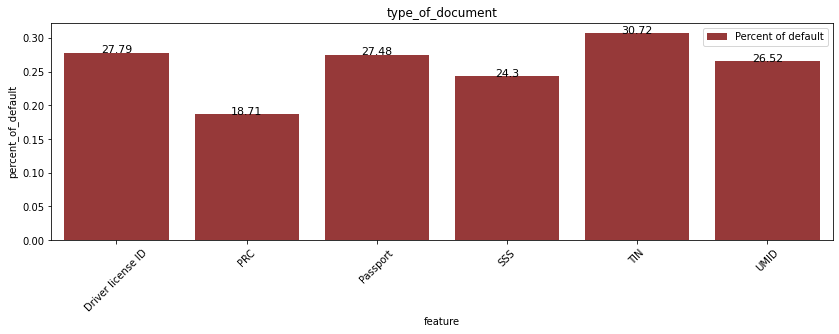

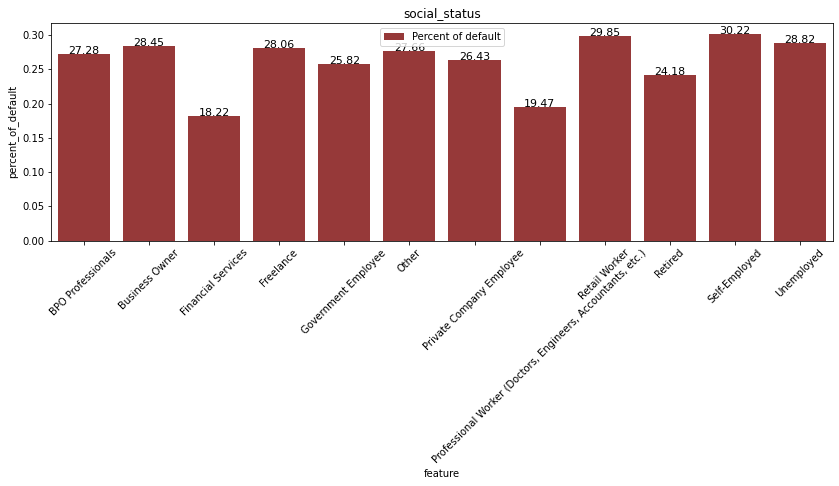

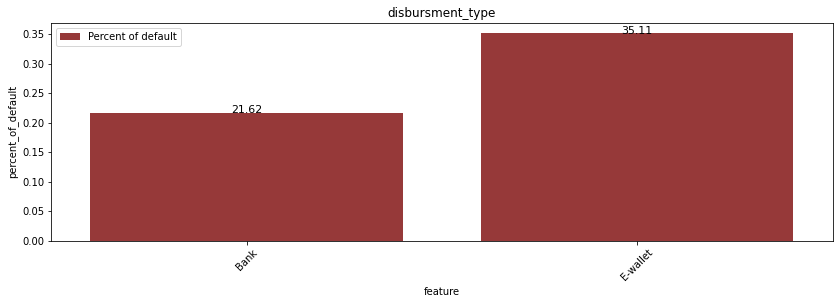

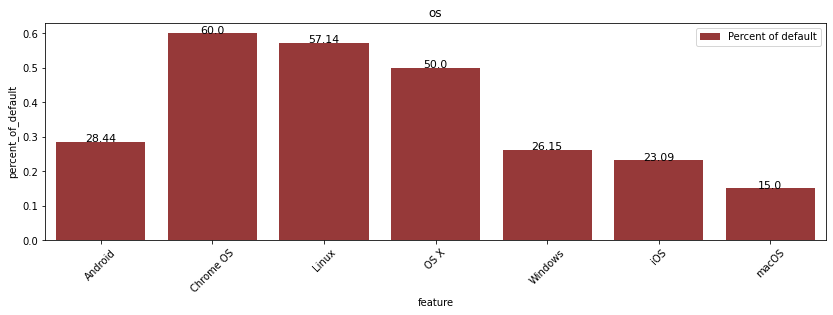

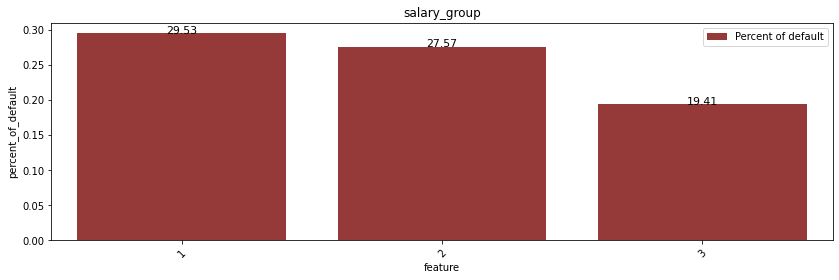

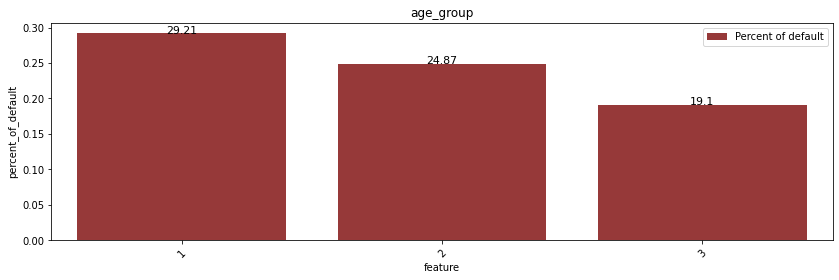

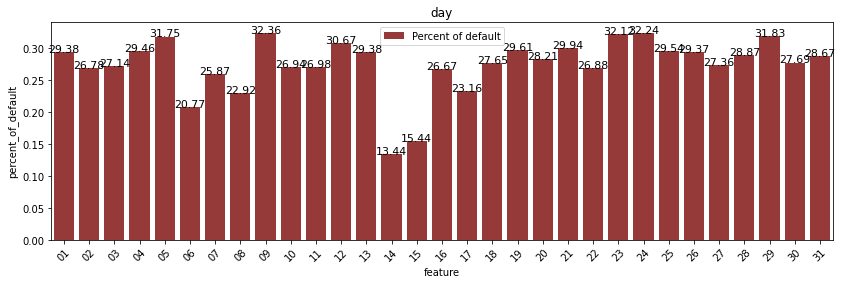

In [84]:
#Посмотрим на то как в процентном соотношении к дефолтным и не дефолтным делятся все признаки из таблицы
column_list = ['device_quaility_index', 'behavioral_index',
       'type_of_document', 'social_status',
       'disbursment_type', 'os', 'salary_group',
       'age_group', 'day']
for column in column_list:
    base_table = data[['fpd5_flg', '%s'%column]].groupby(['%s'%column, 'fpd5_flg']).agg({'fpd5_flg': 'count'})
    
    b = list(base_table.fpd5_flg.values)
    column2=[]
    for i in range(0, len(b)):
        if i%2==0:
            percent=(b[i+1]/(b[i+1]+b[i]))
            column2.append(percent)

    column1=[]
    for i in list(base_table.index): 
        column1.append(i[0])


    table = pd.DataFrame({'feature': list(pd.DataFrame({'val': column1}).val.unique()),'percent_of_default': column2})
    plt.figure(figsize=(14, 4))
    ax = sns.barplot(x=table.feature, y=table.percent_of_default, color='brown', label='Percent of default')

    for index, row in table.iterrows():
        ax.text(row.name, row.percent_of_default, round(row.percent_of_default*100,2),color='black', ha="center", size=11)

    plt.xticks(rotation=45)
    plt.title('%s'%column)
    plt.legend()
    plt.show()
    # print(table) #если хочется посмотреть на сами таблицы 
    print('=='*60)

In [85]:
# Рассмотрим интересные признаки:

In [86]:
#поведенческий индекс: люди с 1 имеют наименьший процент дефолтов, но и их меньше всех, так что отделять людей с индексом 1 может быть не репрезентативно,
# зато люди с индексом 6 имеют самый высокий процент дефолтов хоть и их намного меньше чем людей с индексами 3,4,5 
# индексы уже достаточно неплохо разделяют датасет на категории, но индекс 6 достаточно подозрителен
# Решение: создадим бинарную фичу 
data['behavior_index_six'] = data.behavioral_index.apply(lambda x: 1 if x==6 else 0)
data.behavioral_index.value_counts()

4.0    5112
3.0    4846
5.0    4450
6.0     730
2.0     202
1.0      23
Name: behavioral_index, dtype: int64

In [87]:
#социальный статус: достаточно интересный признак который  по логике должен характеризовать клиентов, отделяя безработных от остальных, но получилось, 
# что клиенты с данным соц статусом имеют процент дефолта на уровне со многими другими, отделились особняком от всех остальным две соц группы 
# люди что работают в Financial Services и Private Company Employee, что говорят, что сотрудники из данных секторов чаще всего выплачивают кредиты 
# при чём если низкий % Financial Services можно списать на недостаточное кол-во в выборке, то Private Company Employee самая большая часть клиентов
#Решение: создадим бинарную фичу 
data['trust_soc_stat'] = data['social_status'].apply(lambda x: 1 if (x=='Private Company Employee' or x=='Financial Services') else 0)
data.social_status.value_counts()

Private Company Employee                                       3500
Self-Employed                                                  2323
BPO Professionals                                              2295
Other                                                          1703
Business Owner                                                 1680
Government Employee                                            1061
Freelance                                                       777
Unemployed                                                      642
Professional Worker (Doctors, Engineers, Accountants, etc.)     642
Retail Worker                                                   402
Financial Services                                              247
Retired                                                          91
Name: social_status, dtype: int64

In [88]:
#день получения кредита: юзеры которые берут кредиты 14-15 числа чаще всего их возвращают. Возможно это связано с тем, 
# что люди берущие их в этот день хотят дотянуть до аванса 15-16 числа, и получив зп сразу отдают кредит 
# ==> создадим бинарный признак 14-15 число или нет
data.day = data.day.astype(int).apply(lambda x: 1 if (x==14 or x==15) else 0)
data = data.rename(columns={'day': 'good_days'})

In [89]:
#Индекс качества девайся: заметно, что люди с индексом 4 в меньшей степени склонны к дефолту 
# ==>создадим бинарный признак
data.device_quaility_index.value_counts()
data['device_index_4'] = data.device_quaility_index.apply(lambda x: 1 if x==4 else 0)

In [90]:
#Формат домена: может озарактеризовать человека если он использует корпоративную почту или домен принадлежащий только пользователям определенной
# техники, что сможет сказать о финансовой благонадёжности, также может сказать о нахождении в определенной местности, если данный домен является 
# локально популярен
# ==> оставляем как данные для обучения 

1    9665
0    5698
Name: gender, dtype: int64

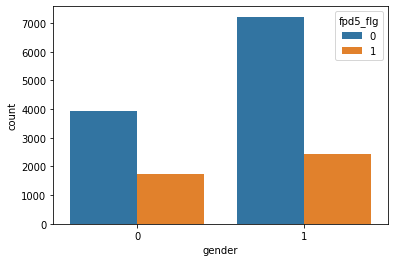

In [91]:
#Пол: незивестно какая цифра какой пол означает, но и это не особсенно важно, даже если видна закономерность что, например, у женщин процент дефолтов в 
# общей совокупности данных выше, чем у мужчин, это может сильно зависить от кол-ва того, что мужчины в прицнипе больше берут кредитов, да и 
# в общем брать такой признак для обучения модели неправильно, т.к. решающий голос может уйти по половой принадлежности, нежели зарплатной составляющей при 
# равенстве последних
sns.countplot(x=data.gender, hue=data['fpd5_flg'])
data.gender.value_counts()

# Model

## Fitting

In [92]:
#Использовать будем catboost, так модель обладает высокой точностью 
# и сама осуществляет стандартизацию данных для тех данных что ей нужно 

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15363 entries, 0 to 15362
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fpd5_flg                15363 non-null  int64  
 1   dt                      15363 non-null  object 
 2   gender                  15363 non-null  int64  
 3   device_quaility_index   15363 non-null  float64
 4   behavioral_index        15363 non-null  float64
 5   type_of_document        15363 non-null  object 
 6   age                     15363 non-null  int64  
 7   email_domain_formatted  15363 non-null  object 
 8   social_status           15363 non-null  object 
 9   salary                  15363 non-null  float64
 10  disbursment_type        15363 non-null  object 
 11  os                      15363 non-null  object 
 12  email_index             15363 non-null  float64
 13  salary_group            15363 non-null  object 
 14  age_group               15363 non-null

In [94]:
data['fpd5_flg'].value_counts(normalize=True)
#в таргетах явный дизбаланс

0    0.727202
1    0.272798
Name: fpd5_flg, dtype: float64

In [95]:
data.columns

Index(['fpd5_flg', 'dt', 'gender', 'device_quaility_index', 'behavioral_index',
       'type_of_document', 'age', 'email_domain_formatted', 'social_status',
       'salary', 'disbursment_type', 'os', 'email_index', 'salary_group',
       'age_group', 'def_fit', 'good_days', 'behavior_index_six',
       'trust_soc_stat', 'device_index_4'],
      dtype='object')

In [96]:

X = data[['device_quaility_index', 'behavioral_index',
       'type_of_document', 'age', 'email_domain_formatted', 'social_status',
       'salary', 'disbursment_type', 'os', 'email_index', 'salary_group',
       'age_group', 'good_days', 'behavior_index_six', 'trust_soc_stat', 'device_index_4']]



y = data.fpd5_flg

cat_features = ['type_of_document', 'email_domain_formatted', 'social_status', 'disbursment_type', 'os', 'salary_group', 'age_group']


In [97]:
X = pd.get_dummies(X)

In [98]:
 #классы не сбалансированы, значит дальнейшая стретегия действий связана либо с существенным редактирование вероятности реузльтата, 
# либо с применением алгоритма SMOTE, который искусственно создаёт баланс, путём создания элементов в непосредственной близости от уже существующих в меньшем наборе
# ==> используем второй способ/
#  т.к. в smote можно задвать только числовые значения придётся отказаться от категориальных признаков в catboost и 
# транформировать такие фичи в разряженные векторазаранее.
X_balance, y_balance = SMOTE(random_state=42).fit_resample(X, y)

In [99]:
y_balance.value_counts()

0    11172
1    11172
Name: fpd5_flg, dtype: int64

In [100]:
y.value_counts()

0    11172
1     4191
Name: fpd5_flg, dtype: int64

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance, train_size = 0.75, random_state=42, stratify = y_balance)
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.85, random_state=42, stratify = y)

In [102]:
model = CatBoostClassifier(iterations=2000,
                           verbose=100,
                           random_state=42,
                           learning_rate=0.03,
                           early_stopping_rounds=300,
                           eval_metric='AUC',
                        #    cat_features=cat_features #использовать если не балансировать классы 
                           )


In [103]:
model.fit(X_train, y_train,
          eval_set=(X_test, y_test))

0:	test: 0.7356058	best: 0.7356058 (0)	total: 157ms	remaining: 5m 13s
100:	test: 0.8513110	best: 0.8513110 (100)	total: 1.16s	remaining: 21.8s
200:	test: 0.8552839	best: 0.8553039 (196)	total: 2.38s	remaining: 21.3s
300:	test: 0.8568807	best: 0.8568811 (299)	total: 3.39s	remaining: 19.1s
400:	test: 0.8577905	best: 0.8577938 (392)	total: 4.38s	remaining: 17.5s
500:	test: 0.8584791	best: 0.8585667 (494)	total: 5.33s	remaining: 16s
600:	test: 0.8589627	best: 0.8590383 (591)	total: 6.29s	remaining: 14.6s
700:	test: 0.8591933	best: 0.8594068 (673)	total: 7.24s	remaining: 13.4s
800:	test: 0.8589993	best: 0.8594068 (673)	total: 8.2s	remaining: 12.3s
900:	test: 0.8587301	best: 0.8594068 (673)	total: 9.17s	remaining: 11.2s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8594068415
bestIteration = 673

Shrink model to first 674 iterations.


In [104]:
# bestTest = 0.8638
# bestIteration = 390

In [105]:
#ТОП 20 фич полвиявших на результат
fi = pd.DataFrame({'w':model.feature_importances_,'name':X.columns}).sort_values('w',ascending=False)
fi.head(20)

,w,name
1,20.682248,behavioral_index
4,13.022360,email_index
0,11.187232,device_quaility_index
122,8.933890,disbursment_type_Bank
14,7.744868,type_of_document_UMID
123,7.050987,disbursment_type_E-wallet
13,5.829161,type_of_document_TIN
9,5.801382,type_of_document_Driver license ID
11,4.313231,type_of_document_Passport
12,3.696301,type_of_document_SSS


## Metrics

In [106]:
#рассмотрим метрику ROC и подберем максимально подходящую границу под вероятность принадлжености класса

In [107]:
y_pred = model.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred))
fpr, tpr, thr = roc_curve(y_test, y_pred)
roc = pd.DataFrame({'fpr':fpr,'tpr':tpr,'thr':thr})

0.8594068414860998


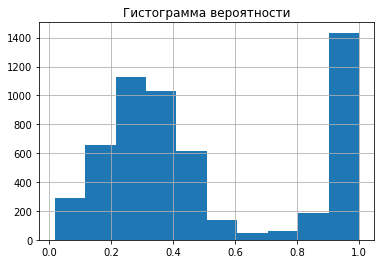

In [108]:
#гистограмма по предсказанной вероятности дефолта 
#модель достаточно хорошо отделяет объекты 1 класса от объектов 0 класса
pd.DataFrame({'Гистограмма вероятности': y_pred}).hist();

<AxesSubplot:xlabel='fpr'>

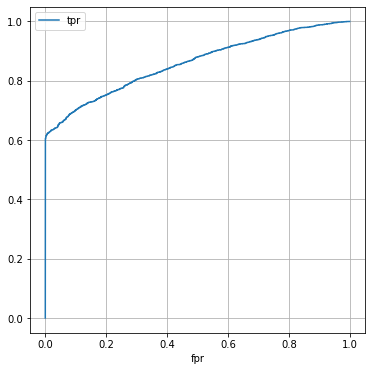

In [109]:
roc.plot(x='fpr',y='tpr',figsize=(6,6),grid=True)

In [110]:
#Подберём лучшую границу вероятности для классификации, при условии, что tpr и fpr "стоят" одинаково 
#Так как сейчас классы сбалансированы граница будет рядом с числом 0.5
#Находим разницу долей правильно определенных объектов первого класса и долей неправильно определенных объектов 
# нулевого класса, должна быть Максимальна

roc['tpr-fpr'] = roc['tpr'] - roc['fpr']
best_thr = roc.sort_values('tpr-fpr',ascending=False)['thr'].iloc[0]


In [111]:
#так и вышло, лучшая граница 0.56
roc.sort_values('tpr-fpr',ascending=False)

,fpr,tpr,thr,tpr-fpr
57,0.006803,0.622628,0.579838,0.615825
59,0.007161,0.622986,0.577608,0.615825
58,0.007161,0.622628,0.577979,0.615467
61,0.007877,0.623344,0.574846,0.615467
60,0.007877,0.622986,0.575056,0.615109
...,...,...,...,...
1584,0.993197,1.000000,0.045830,0.006803
1583,0.993197,0.999642,0.046092,0.006445
1,0.000000,0.000358,0.999981,0.000358
0,0.000000,0.000000,1.999981,0.000000


In [112]:
#Вероятность больше которой модель принимает решение при условии равенства весов ошибок 

#При не сбалансированных классах граница бы лежала в области ~0.25, то есть если вероятность дефолта хотя бы 25%, то его определяют как дефолт
best_thr = roc.sort_values('tpr-fpr',ascending=False)['thr'].iloc[0] 
print(best_thr)
y_pred_binary = (y_pred > best_thr) * 1

0.5798379529730754


In [113]:
print(classification_report(y_test, y_pred_binary))
#f1 вышел неплохим 76%
# recall для положительного класса всё равно определяется плохо, требуется доработка модели

              precision    recall  f1-score   support

           0       0.72      0.99      0.84      2793
           1       0.99      0.62      0.76      2793

    accuracy                           0.81      5586
   macro avg       0.86      0.81      0.80      5586
weighted avg       0.86      0.81      0.80      5586



In [114]:
#добавление предикта в изначальную таблицу 
data['Probability_of_default'] = model.predict_proba(X)[:,1]
data_initial['Probability_of_default(%)'] = data['Probability_of_default'] 

In [115]:
#Выгрузка
# data_initial.to_excel('Test Sample with proba of default.xlsx')

## Cost matrix (additional part)

In [116]:
#Посмотрим на модель под углом кредитной организации

#Ошибка первого и второго рода стоят абсолютно по разному, кредитной организации гораздо лучше, то есть дешевле, отказать хорошему клиенту 
#(НЕПРАВИЛЬНО определить вероятность выдачи кредита для хорошего клиента, который его Вернёт,сказать что "он не вернёт"), 
# чем резрешить плохому клиенту взять кредит (НЕПРАВИЛЬНО определить вероятность выдачи кредита, который его НЕ Вернет, сказать, что "он вернёт")
#
#Можем для анализа добавить матрицу цен ошибки, которую вывели в университете Гамбурга для датасета "German Credit Data"  
# (каждая коедитная организация обычно использует свои веса)

# https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data):

# """
#        1 2 
# ----------------------------
# 1     0 1 
# -----------------------
# 2     5 0

# 1 = Good, 2 = Bad)
# The rows represent the actual classification and the columns the predicted classification.
# It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).
# """

#Надо учесть что в матрице выше значения 1 и 2 - это значения не классов, а сама характеристика 
# Получается для данного датасета ошибка второго рода (выдать дефолту (False Negative)) стоит в 5 раз дороже, 
# чем ошибка первого рода (не выдать хорошему(False Positive))
# TP - просто дефолт и он определился как дефолт, TN - определили как не дефолт правильно



In [117]:
# необходимо посчитать для каждого возможного порога confusion matrix чтобы получить все исходы по tn, fn, 
# применить матрицу стоимости ошибок и узнать самый лучший порог, это там где ошибка fn будет минимальна 

In [118]:
thrs = list(pd.DataFrame({'prob': y_pred}).prob.unique())
res = []
for thr in tqdm(thrs):
  y_pred_binary = (y_pred > thr) * 1
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
  res.append((tn, fp, fn, tp ,thr))

  0%|          | 0/5556 [00:00<?, ?it/s]

In [119]:
con_matrix = pd.DataFrame(res, columns=['tn', 'fp', 'fn', 'tp','thr'])
# tp не берется потому, что это исход когда ничего не теряется и не зарабатывается 
con_matrix['prof_threshols'] = con_matrix['tn'] - 5 * con_matrix['fn'] - con_matrix['fp']

In [120]:
con_matrix = con_matrix.sort_values(by='prof_threshols', ascending=False)
con_matrix

,tn,fp,fn,tp,thr,prof_threshols
5189,1948,845,542,2251,0.349853,-1607
2196,1958,835,546,2247,0.350993,-1607
362,1945,848,541,2252,0.349263,-1608
4045,1950,843,543,2250,0.350279,-1608
3952,1957,836,546,2247,0.350868,-1609
...,...,...,...,...,...,...
897,2793,0,2789,4,0.999952,-11152
3473,2793,0,2790,3,0.999961,-11157
4243,2793,0,2791,2,0.999970,-11162
746,2793,0,2792,1,0.999974,-11167


In [121]:
Final_threshold = con_matrix.thr.iloc[0]
Final_threshold

0.3498533371988623

In [122]:
# ==>Вывод: порог ~34%, то есть даже если есть небольшая вероятность 34%, то модель считает что это дефолт